- 凝聚层次聚类：
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
- K邻居加权：http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html#sklearn.neighbors.kneighbors_graph

- 层次聚类方法对给定的数据集进行层次的分解，直到满足某种条件为止，传统的层次聚类算法主要分为两大类算法：
    - 凝聚的层次聚类：AGNES算法(AGglomerative NESting)==>采用自底向上的策略。最初将每个对象作为一个簇，然后这些簇根据某些准则被一步一步合并，两个簇间的距离可以由这两个不同簇中距离最近的数据点的相似度来确定；聚类的合并过程反复进行直到所有的对象满足簇数目。
    - 分裂的层次聚类：DIANA算法(DIvisive ANALysis)==>采用自顶向下的策略。首先将所有对象置于一个簇中，然后按照某种既定的规则逐渐细分为越来越小的簇(比如最大的欧式距离)，直到达到某个终结条件(簇数目或者簇距离达到阈值)。

In [11]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import sklearn.datasets as ds
import warnings

In [12]:
## 设置属性防止中文乱码及拦截异常信息
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore', category=UserWarning)

In [13]:
## 模拟数据产生: 产生600条数据
np.random.seed(0)
n_clusters = 4
N = 1000
data1, y1 = ds.make_blobs(n_samples=N, n_features=2, centers=((-1, 1), (1, 1), (1, -1), (-1, -1)), random_state=0)

n_noise = int(0.1*N)
r = np.random.rand(n_noise, 2)
min1, min2 = np.min(data1, axis=0)
max1, max2 = np.max(data1, axis=0)
r[:, 0] = r[:, 0] * (max1-min1) + min1
r[:, 1] = r[:, 1] * (max2-min2) + min2

data1_noise = np.concatenate((data1, r), axis=0)
y1_noise = np.concatenate((y1, [4]*n_noise))
# 拟合出的是月牙形数据
data2, y2 = ds.make_moons(n_samples=N, noise=.05)
data2 = np.array(data2)
n_noise = int(0.1 * N)
r = np.random.rand(n_noise, 2)
min1, min2 = np.min(data2, axis=0)
max1, max2 = np.max(data2, axis=0)
r[:, 0] = r[:, 0] * (max1 - min1) + min1
r[:, 1] = r[:, 1] * (max2 - min2) + min2
data2_noise = np.concatenate((data2, r), axis=0)
y2_noise = np.concatenate((y2, [3] * n_noise))

In [14]:
# import pygal

In [15]:
def expandBorder(a, b):
    d = (b - a) * 0.1
    return a-d, b+d

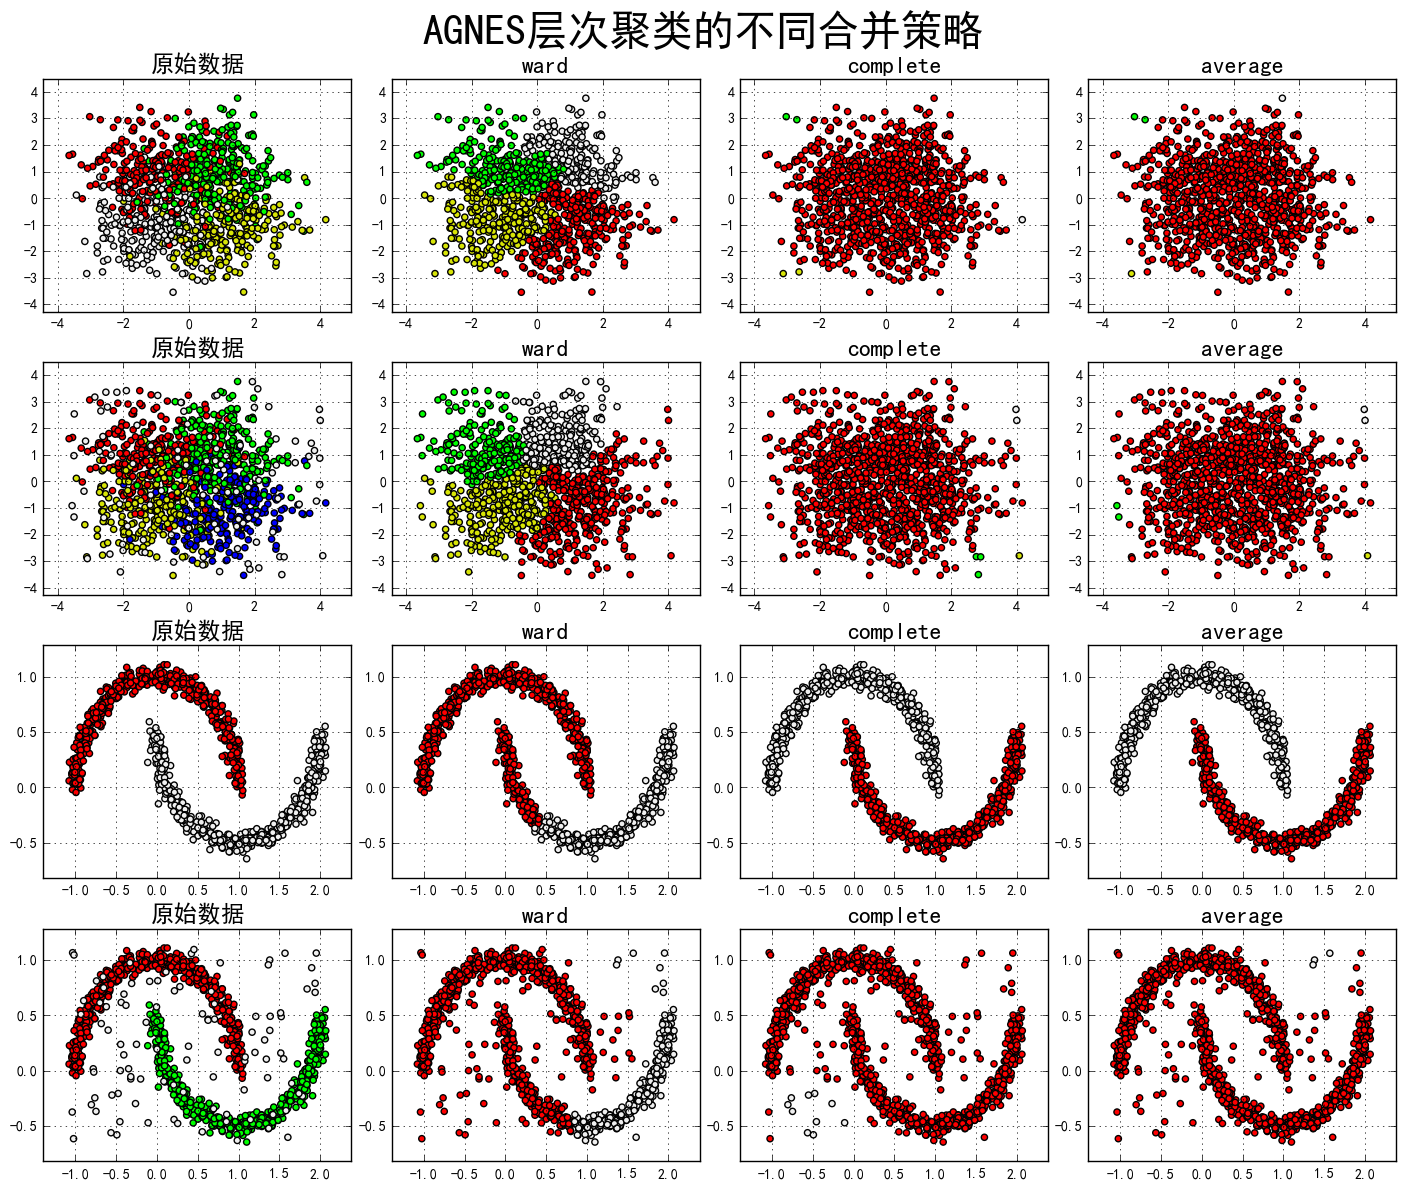

In [16]:
## 画图
cm = mpl.colors.ListedColormap(['#FF0000', '#00FF00',  '#0000FF', '#d8e507', '#F0F0F0'])
plt.figure(figsize=(14, 12), facecolor='w')
linkages = ("ward", "complete", "average") # 把质心法、最大距离、平均距离法放到list里，后面直接循环取值
for index, (n_clusters, data, y) in enumerate(((4, data1, y1), (4, data1_noise, y1_noise),
                                               (2, data2, y2), (2, data2_noise, y2_noise))):
    
    plt.subplot(4, 4, 4*index+1)
    plt.scatter(data[:, 0], data[:, 1], c=y, cmap=cm)
    plt.title(u'原始数据', fontsize=17) # 画散点图
    plt.grid(b=True, ls=':')
    min1, min2 = np.min(data, axis=0)
    max1, max2 = np.max(data, axis=0)
    plt.xlim(expandBorder(min1, max1))
    plt.ylim(expandBorder(min2, max2))

    # n_neighbors 每个样本的邻居数量
    # include_self bool，默认= False 是否将每个样本标记为自己的第一个最近的邻居
    # 如果include_self为True，mode ='connectivity'，False for mode ='distance'
    # metric 默认“minkowski”用于计算每个采样点的k邻居的距离度量。
    connectivity = kneighbors_graph(data, n_neighbors=7, mode='distance', metric='minkowski', p=2, include_self=True)
    connectivity = 0.5 * (connectivity + connectivity.T)
    for i, linkage in enumerate(linkages):
        # 凝聚层次聚类 
        # affinity 默认 “euclidean”default: “euclidean”
        # Metric used to compute the linkage. Can be “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or ‘precomputed’. 
        # If linkage is “ward”, only “euclidean” is accepted.
        ac = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean',
                                     connectivity=connectivity, linkage=linkage)
        ac.fit(data)
        y = ac.labels_
        
        plt.subplot(4, 4, i+2+4*index)
        plt.scatter(data[:, 0], data[:, 1], c=y, cmap=cm)
        plt.title(linkage, fontsize=17)
        plt.grid(b=True, ls=':')
        plt.xlim(expandBorder(min1, max1))
        plt.ylim(expandBorder(min2, max2))

plt.suptitle(u'AGNES凝聚层次聚类的不同合并策略', fontsize=30)
plt.tight_layout(0.5, rect=(0, 0, 1, 0.95))
plt.show()

In [17]:
# K-means的初始K是指定的，所以最后类别数量肯定是K。但是层次聚类最后不一定是K类
# K-means不能很好的处理月牙型数据，能有效处理类圆型数据
# 最后一行意义：层次聚类不能很好的处理噪声点（噪声点可以用密度聚类解决）